# Introduction
- In this kernel, we will be implementing an example environment.
- We will be deploying SARSA, Q-Learning and Expected SARSA to try and find the optimal agent's policy and the optimal value functions, in order to maximize the rewards.

# Importing Packages & Boilerplate Stuff

1. jdc: Jupyter magic that allows defining classes over multiple jupyter notebook cells.
2. numpy: the fundamental package for scientific computing with Python.
3. matplotlib: the library for plotting graphs in Python.
4. RL-Glue: the library for reinforcement learning experiments.
5. BaseEnvironment, BaseAgent: the base classes from which we will inherit when creating the environment and agent classes in order for them to support the RL-Glue framework.
6. itertools.product: the function that can be used easily to compute permutations.
7. tqdm.tqdm: Provides progress bars for visualizing the status of loops.

# Based on Version_2 (Changes)
- Altered the transition matrix to be action dependent

In [1]:
import jdc
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import product
from tqdm import tqdm

In [2]:
### DEBUG CODE
# Setting the seed for reproducible results
# np.random.seed(0)

# 1. Environment
- The below code cell provides the backbone of the `ExampleEnvironment` class.

In [3]:
class ExampleEnvironment():
    def __init__(self, env_info={}):
        # These are the different possible states
        self.grid = [0, 1, 2, 3]
        
        # The rewards produced by the environment in response to the different ...
        # ... actions of the agent in different states
        self.rewards = [
            [0, 0, 2],
            [0, 1, 0],
            [1, 1, 0],
            [2, 1.5, 3]
        ]

        # The environment is governed by the following dynamics
        # In mathematical notation, this is nothing but p(s'|s,a)
        # But in this example, we are assuming to be independent of actions, i.e., ...
        # p(s'|s, a) is equal for all actions in state s
        self.tran_matrix = np.array([
            [
                # State 0
                [1/2, 1/2, 0, 0],      # Action 0
                [1, 0, 0, 0],          # Action 1
                [0, 1/4, 1/4, 1/2]     # Action 2
            ],
            [
                # State 1
                [1/2, 1/4, 1/4, 0],    # Action 0
                [1/4, 1/4, 1/4, 1/4],  # Action 1
                [1/2, 1/4, 1/4, 0]     # Action 2
            ],
            [
                # State 2
                [1/4, 1/4, 0, 1/2],    # Action 0
                [1/2, 0, 0, 1/2],      # Action 1
                [1/2, 0, 1/2, 0]       # Action 2
            ],
            [
                # State 3
                [0, 0, 0, 1],          # Action 0
                [0, 0, 1/2, 1/2],      # Action 1
                [1/4, 1/4, 1/4, 1/4]   # Action 2
            ]
        ])
        
        # Defining a random generator
        self.rand_generator = np.random.RandomState(env_info.get("seed", 0))
        
        # Defines the current location
        self.cur_loc = None
        
    def start(self):
        self.cur_loc = self.rand_generator.choice(self.grid)
        return self.cur_loc
    
    def step(self, action):
        next_reward = self.rewards[self.cur_loc][action]
        next_state = self.rand_generator.choice(self.grid, 
            p = self.tran_matrix[self.cur_loc][action])
        self.cur_loc = next_state
        return next_state, next_reward

# 2. Value Iteration

In [4]:
def value_iteration(theta = 0.01, discount = 0.9):
    # Creating an instance for the environment
    env = ExampleEnvironment()

    # Defining the paramters for the simulation
    delta = theta * 10

    # Initializing the state values and the different possible actions
    s_vals = np.zeros(4)
    actions = list(np.arange(3))

    while delta > theta:
        delta = 0
        for s in env.grid:
            cur_val = copy.copy(s_vals[s])
            vals = []
            for a in actions:
                sum_rhs = env.tran_matrix[s][a] * (env.rewards[s][a] + discount * s_vals)
                vals.append(np.sum(sum_rhs))
            s_vals[s] = np.max(vals)
            delta = max(delta, abs(cur_val - s_vals[s]))
            
    return s_vals

In [5]:
s_vals = value_iteration(theta = 0.001, discount = 0.9)
print("Post Convergence of Value Iteration Algorithm")
print("State Values: ", s_vals)

s_vals = value_iteration(theta = 0.001, discount = 0.8)
print("\nPost Convergence of Value Iteration Algorithm")
print("State Values: ", s_vals)

s_vals = value_iteration(theta = 0.001, discount = 0.7)
print("\nPost Convergence of Value Iteration Algorithm")
print("State Values: ", s_vals)

Post Convergence of Value Iteration Algorithm
State Values:  [19.65802034 18.47442489 19.05940921 20.47481728]

Post Convergence of Value Iteration Algorithm
State Values:  [ 9.85902608  8.69242815  9.22041673 10.69277734]

Post Convergence of Value Iteration Algorithm
State Values:  [6.59151427 5.44263636 5.91181579 7.44293702]


In [6]:
def value_iteration_using_q(theta = 0.01, discount = 0.9):
    # Creating an instance for the environment
    env = ExampleEnvironment()

    # Defining the paramters for the simulation
    delta = theta * 10

    # Initializing the action values and the different possible actions
    rand_generator = np.random.RandomState(0)
    q_vals = rand_generator.uniform(0, 0.1, (4, 3))
    # q_vals = np.zeros((4, 3))
    actions = list(np.arange(3))

    while delta > theta:
        delta = 0
        for s in env.grid:
            for a in actions:
                cur_val = copy.copy(q_vals[s][a])
                sum_rhs = 0
                for next_s in env.grid:
                    sum_rhs += env.tran_matrix[s][a][next_s] * (
                        env.rewards[s][a] + discount * max(q_vals[next_s]) 
                    )
                q_vals[s][a] = sum_rhs
                delta = max(delta, abs(cur_val - q_vals[s][a]))

    return q_vals

In [7]:
q_vals = value_iteration_using_q(theta = 0.001, discount = 0.9)
print("Post Convergence of Value Iteration Algorithm")
print("Action Values: ", q_vals)
print("State Values: ", np.max(q_vals, axis = 1))

q_vals = value_iteration_using_q(theta = 0.001, discount = 0.8)
print("\nPost Convergence of Value Iteration Algorithm")
print("Action Values: ", q_vals)
print("State Values: ", np.max(q_vals, axis = 1))

q_vals = value_iteration_using_q(theta = 0.001, discount = 0.7)
print("\nPost Convergence of Value Iteration Algorithm")
print("Action Values: ", q_vals)
print("State Values: ", np.max(q_vals, axis = 1))

Post Convergence of Value Iteration Algorithm
Action Values:  [[17.15931443 17.69192995 19.65851276]
 [17.29130523 18.47490899 17.29148502]
 [18.79355817 19.05986902 17.4232718 ]
 [20.42707655 19.29047933 20.47525956]]
State Values:  [19.65851276 18.47490899 19.05986902 20.47525956]

Post Convergence of Value Iteration Algorithm
Action Values:  [[ 7.42030911  7.88694371  9.85944211]
 [ 7.52621882  8.69283046  7.52636628]
 [ 8.98745465  9.22077698  7.63208764]
 [10.55400027  9.46531093 10.69310998]]
State Values:  [ 9.85944211  8.69283046  9.22077698 10.69310998]

Post Convergence of Value Iteration Algorithm
Action Values:  [[4.21210196 4.6142129  6.59217773]
 [4.29435816 5.44326794 4.29443229]
 [5.71128477 5.91234399 4.3765826 ]
 [7.21016356 6.17440218 7.44340408]]
State Values:  [6.59217773 5.44326794 5.91234399 7.44340408]


In [8]:
optimal_q_vals = value_iteration_using_q(theta = 0.01, discount = 0.9)
print("Optimal Action Values: ", optimal_q_vals)
print("Optimal State Values: ", np.max(optimal_q_vals, axis = 1))

Optimal Action Values:  [[17.1181036  17.65036821 19.6199304 ]
 [17.25402588 18.43697814 17.25588622]
 [18.75767762 19.02384188 17.38969752]
 [20.38974639 19.25560204 20.44060544]]
Optimal State Values:  [19.6199304  18.43697814 19.02384188 20.44060544]


# 3. Q Learning Agent

In [9]:
class QLearningAgent():
    def __init__(self, agent_info={}):
        # Defining the #actions and #states 
        self.num_actions = 3
        self.num_states = 4
        
        # Discount factor (gamma) to use in the updates.
        self.discount = agent_info.get("discount", 0.9)

        # The learning rate or step size parameter (alpha) to use in updates.
        self.step_size = agent_info.get("step_size", 0.1)
        
        # Whether the step-size is decreasing or not
        self.is_step_decreasing = agent_info.get("is_step_decreasing", False)
        
        if self.is_step_decreasing:
            # The ratio by which the step-size should be multiplied
            self.reduce_step_with = agent_info.get("reduce_step_with", 0.9)
            
            # The number of steps after which the step-size should be reduced
            self.reduce_step_after = agent_info.get("reduce_step_after", 100)

        # To control the exploration-exploitation trade-off
        self.epsilon = agent_info.get("epsilon", 0.1)
        
        # To determine if the Q-function is converged or not
        self.delta = agent_info.get("delta", 0.01)
        
        # Defining a random generator
        self.rand_generator = np.random.RandomState(agent_info.get("seed", 0))
        
        # Definining the Optimal Q-Values to which the algorithm should converge to
        self.optimal_q = agent_info.get("optimal_q", None)
        
        # Defining the initial action values
        # self.q = self.rand_generator.randn(self.num_states, self.num_actions)
        self.q = self.rand_generator.uniform(0, 0.1, (self.num_states, self.num_actions))
        
        # Initializing the variables for the previous state and action
        self.prev_state  = None
        self.prev_action = None
        
        # Tracking the number of steps
        self.cur_step = 0
        
    def start(self, state):
        # Increasing the count of steps
        self.cur_step += 1
        
        # Choose action using epsilon greedy.
        current_q = self.q[state][:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
            
        # Reducing the step-size
        if self.is_step_decreasing and self.cur_step % self.reduce_step_after == 0:
            old_step_size = copy.copy(self.step_size)
            self.step_size *= self.reduce_step_with
            # print(f"At {self.cur_step} steps | Reduced step-size from {old_step_size} to {self.step_size}")
            
        self.prev_state = state
        self.prev_action = action
        return self.cur_step, action
    
    def step(self, state, reward):
        # Increasing the count of steps
        self.cur_step += 1
        
        # Choose action using epsilon greedy.
        current_q = self.q[state][:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
            
        # Reducing the step-size
        if self.is_step_decreasing and self.cur_step % self.reduce_step_after == 0:
            old_step_size = copy.copy(self.step_size)
            self.step_size *= self.reduce_step_with
            # print(f"At {self.cur_step} steps | Reduced step-size from {old_step_size} to {self.step_size}")
        
        # Determining the new Q-Value
        new_val = -1e8
        cur_val = copy.copy(self.q[self.prev_state, self.prev_action])
        for act in range(self.num_actions):
            val = cur_val + self.step_size * (
                reward + self.discount * self.q[state, act] - cur_val
            )
            new_val = max(new_val, val)
        self.q[self.prev_state, self.prev_action] = new_val
        
        self.prev_state = state
        self.prev_action = action
            
        # Determining if the Q-function has converged or not
        if np.max(np.abs(self.optimal_q - self.q)) < self.delta:
            return (self.cur_step, action, True)
        else:
            return (self.cur_step, action, False)
            
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

# 4. Running Experiments

In [10]:
def run_experiment(
        env_info = {}, agent_info = {}, max_iter = 1000, 
        re_init = 100, print_vals = True
    ):
    env = ExampleEnvironment(env_info) 
    agent = QLearningAgent(agent_info)
    has_converged = False
    
    init_state  = env.start()                             # STARTING STATE
    num_iter, init_action = agent.start(init_state)       # STARTING ACTION
    next_state, next_reward = env.step(init_action)       # STARTING REWARD
    
    while not has_converged and num_iter < max_iter:
        # After every `re_init` steps, re-initialize with a random state
        if num_iter % re_init == 0:
            init_state  = env.start()                             
            num_iter, init_action = agent.start(init_state)                 
            next_state, next_reward = env.step(init_action)
        else:
            num_iter, next_action, has_converged = agent.step(next_state, next_reward)
            next_state, next_reward = env.step(next_action)
            
        if print_vals and num_iter % (max_iter / 5) == 0:
            print(f"\nTime Steps Elapsed | {num_iter}")
            print("Q-Values:", agent.q)
            print()
                
    print("POST CONVERGENCE\n")
    print("Optimal Action Values:")
    print(agent.q)
    
    print("\nOptimal State Values:")
    print(np.max(agent.q, axis = -1))
    
    print("\nOptimal Policy:")
    print(np.argmax(agent.q, axis = -1))
    
    return agent.q

## 4.1.
- **Step-size**: 0.1
- **Step-size decreases**: False
- **Max iterations**: 5000
- **Re-initialization with random state**: False

In [11]:
# Defining the characteristics for the environment
env_info = {
    "seed": 0
}

# Defining the characteristics for the agent
agent_info = {
    "discount": 0.9,       
    "step_size": 0.1,
    "is_step_decreasing": False,
    "epsilon": 0.2,
    "delta": 1e-2,
    "optimal_q": optimal_q_vals,
    "seed": 0
}

max_iter = 5000
re_init = max_iter + 1

# q_vals = run_experiment(
#     env_info, agent_info, max_iter = max_iter, re_init = re_init,
# )

Time Steps Elapsed | 1000 \
Q-Values: [[5.04216496 4.73816578 9.30679299]
 [2.89372637 4.01154449 6.86549132]
 [5.63611153 8.71908135 6.84078173]
 [7.82735768 9.12161954 7.91271621]]


Time Steps Elapsed | 2000 \
Q-Values: [[ 9.36682313  9.98172457 15.90237908]
 [ 7.61125351 10.33710252 13.49351529]
 [11.53587082 15.38563191 11.27887736]
 [13.63514832 13.65590203 16.83990908]]


Time Steps Elapsed | 3000 \
Q-Values: [[12.94828535 14.98426596 17.68840589]
 [13.30663088 13.62057472 15.0185103 ]
 [14.31552017 17.14447614 14.18019127]
 [17.55890443 16.94609547 18.3536544 ]]


Time Steps Elapsed | 4000 \
Q-Values: [[13.79491723 15.24065997 18.95081589]
 [13.79163549 15.03593642 15.57131079]
 [16.28180637 18.49654723 15.08596561]
 [19.99133503 18.6291284  18.8840936 ]]


Time Steps Elapsed | 5000 \
Q-Values: [[14.51410314 16.16093402 19.32599707]
 [14.69012077 15.68262132 16.2723351 ]
 [16.54247403 18.71481266 15.8883882 ]
 [20.00023003 18.79512172 19.91241734]]

**POST CONVERGENCE**

Optimal Action Values: \
[[14.51410314 16.16093402 19.32599707]
 [14.69012077 15.68262132 16.2723351 ]
 [16.54247403 18.71481266 15.8883882 ]
 [20.00023003 18.79512172 19.91241734]]

Optimal State Values: \
[19.32599707 16.2723351  18.71481266 20.00023003]

Optimal Policy: \
[2 2 1 0]

## 4.2.
- **Step-size**: 0.18
- **Step-size decreases**: True
- **Step-size decreases after (#iterations)**: 2000
- **Step-size reduces to (ratio of step-size)**: 0.9
- **Max iterations**: 40000
- **Re-initialization with random state**: False

In [12]:
# Defining the characteristics for the environment
env_info = {
    "seed": 0
}

# Defining the characteristics for the agent
agent_info = {
    "discount": 0.9,       
    "step_size": 0.18,
    "is_step_decreasing": True,
    "reduce_step_after": 2000,
    "reduce_step_with": 0.9,
    "epsilon": 0.2,
    "delta": 1e-2,
    "optimal_q": optimal_q_vals,
    "seed": 0
}

max_iter = 40000
re_init = max_iter + 1

# q_vals = run_experiment(
#     env_info, agent_info, max_iter = max_iter, re_init = re_init,
# )

Time Steps Elapsed | 8000 \
Q-Values: [[16.5931506  17.40776293 19.45035167]
 [16.39568348 18.43663018 17.05046224]
 [18.38434351 18.92814418 17.11178671]
 [20.03532996 18.96784069 19.9869772 ]]


Time Steps Elapsed | 16000 \
Q-Values: [[17.11849233 17.63965619 19.63587644]
 [17.15394769 18.45395947 17.23379926]
 [18.83170275 18.81752592 17.34896179]
 [20.1016044  19.35128526 20.1759893 ]]


Time Steps Elapsed | 24000 \
Q-Values: [[17.24332281 17.68851529 19.7979361 ]
 [17.26886865 18.60188107 17.25347112]
 [18.84305564 18.98835208 17.37795005]
 [20.31876734 19.24440817 20.45555587]]


Time Steps Elapsed | 32000 \
Q-Values: [[17.22257149 17.63609419 19.42716742]
 [17.27728081 18.27281922 17.27157855]
 [18.78754611 18.92410196 17.41346751]
 [20.12631187 19.13055429 20.20187257]]


Time Steps Elapsed | 40000 \
Q-Values: [[17.17416951 17.70279681 19.86057174]
 [17.27534266 18.69890434 17.26961169]
 [18.79029197 19.24124974 17.44479321]
 [20.47763235 19.3034689  20.82593539]]

**POST CONVERGENCE**

Optimal Action Values: \
[[17.17416951 17.70279681 19.86057174]
 [17.27534266 18.69890434 17.26961169]
 [18.79029197 19.24124974 17.44479321]
 [20.47763235 19.3034689  20.82593539]]

Optimal State Values: \
[19.86057174 18.69890434 19.24124974 20.82593539]

Optimal Policy: \
[2 1 1 2]

# 5. Exploration of Hyper-parameters
## 5.1. Trying to understand the effect of step-size
- **Step-size**: Varying
- **Step-size decreases**: True
- **Step-size decreases after (#iterations)**: 2000
- **Step-size reduces to (ratio of step-size)**: 0.9
- **Max iterations**: 40000
- **Re-initialization with random state**: False

In [13]:
step_sizes = np.arange(0.1, 0.51, 0.05)

# Defining the characteristics for the environment
env_info = {
    "seed": 0
}

# Defining the characteristics for the agent
agent_info = {
    "discount": 0.9,       
    "is_step_decreasing": True,
    "reduce_step_after": 2000,
    "reduce_step_with": 0.9,
    "epsilon": 0.2,
    "delta": 1e-2,
    "optimal_q": optimal_q_vals,
    "seed": 0
}

max_iter = 40000
re_init = max_iter + 1
state_vals_ss = []

for ss in step_sizes:
    print("\n\nFor step-size:", ss)
    agent_info['step_size'] = ss
    q_vals = run_experiment(
        env_info, agent_info, max_iter = max_iter, re_init = re_init, print_vals = False
    )
    state_vals = np.max(q_vals, axis = -1)
    state_vals_ss.append(state_vals)



For step-size: 0.1
POST CONVERGENCE

Optimal Action Values:
[[17.16738529 17.69788719 19.7871388 ]
 [17.28477101 18.62479208 17.28288315]
 [18.7834697  19.18237595 17.42740723]
 [20.42977956 19.23209843 20.72032476]]

Optimal State Values:
[19.7871388  18.62479208 19.18237595 20.72032476]

Optimal Policy:
[2 1 1 2]


For step-size: 0.15000000000000002
POST CONVERGENCE

Optimal Action Values:
[[17.18296406 17.7208673  19.844204  ]
 [17.30120492 18.68356881 17.2884758 ]
 [18.80826934 19.22937588 17.45937893]
 [20.47047305 19.29037509 20.79976216]]

Optimal State Values:
[19.844204   18.68356881 19.22937588 20.79976216]

Optimal Policy:
[2 1 1 2]


For step-size: 0.20000000000000004
POST CONVERGENCE

Optimal Action Values:
[[17.19560602 17.72985373 19.89574146]
 [17.30726537 18.73480794 17.30444687]
 [18.81313737 19.27553901 17.47552207]
 [20.52378974 19.34876799 20.86618945]]

Optimal State Values:
[19.89574146 18.73480794 19.27553901 20.86618945]

Optimal Policy:
[2 1 1 2]


For step-

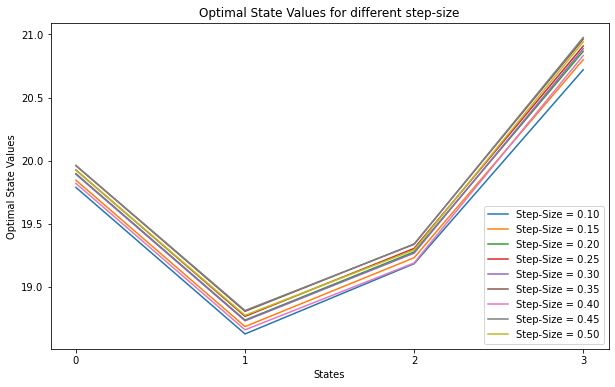

In [14]:
plt.figure(figsize = (10, 6))

for i in range(len(step_sizes)):
    plt.plot(state_vals_ss[i], label = f'Step-Size = {"%.2f" % step_sizes[i]}')
    
plt.xticks(np.arange(4))
plt.title("Optimal State Values for different step-size")
plt.xlabel("States")
plt.ylabel("Optimal State Values")
plt.legend()
plt.show()

## 5.2. Trying to understand the effect of epsilon
- **Step-size**: 0.18
- **Step-size decreases**: True
- **Step-size decreases after (#iterations)**: 2000
- **Step-size reduces to (ratio of step-size)**: 0.9
- **Max iterations**: 40000
- **Re-initialization with random state**: False

In [15]:
eps = np.arange(0.1, 0.51, 0.05)

# Defining the characteristics for the environment
env_info = {
    "seed": 0
}

# Defining the characteristics for the agent
agent_info = {
    "discount": 0.9,       
    "step_size": 0.18,
    "is_step_decreasing": True,
    "reduce_step_after": 2000,
    "reduce_step_with": 0.9,
    "delta": 1e-2,
    "optimal_q": optimal_q_vals,
    "seed": 0
}

max_iter = 40000
re_init = max_iter + 1
state_vals_eps = []

for e in eps:
    print("\n\nFor epsilon:", e)
    agent_info['epsilon'] = ss
    q_vals = run_experiment(
        env_info, agent_info, max_iter = max_iter, re_init = re_init, print_vals = False
    )
    state_vals = np.max(q_vals, axis = -1)
    state_vals_eps.append(state_vals)



For epsilon: 0.1
POST CONVERGENCE

Optimal Action Values:
[[17.27362112 17.77952547 19.79796835]
 [17.36425319 18.73716751 17.31298329]
 [18.97857985 19.10496673 17.45359498]
 [20.49528598 19.26564892 20.63713376]]

Optimal State Values:
[19.79796835 18.73716751 19.10496673 20.63713376]

Optimal Policy:
[2 1 1 2]


For epsilon: 0.15000000000000002
POST CONVERGENCE

Optimal Action Values:
[[17.27362112 17.77952547 19.79796835]
 [17.36425319 18.73716751 17.31298329]
 [18.97857985 19.10496673 17.45359498]
 [20.49528598 19.26564892 20.63713376]]

Optimal State Values:
[19.79796835 18.73716751 19.10496673 20.63713376]

Optimal Policy:
[2 1 1 2]


For epsilon: 0.20000000000000004
POST CONVERGENCE

Optimal Action Values:
[[17.27362112 17.77952547 19.79796835]
 [17.36425319 18.73716751 17.31298329]
 [18.97857985 19.10496673 17.45359498]
 [20.49528598 19.26564892 20.63713376]]

Optimal State Values:
[19.79796835 18.73716751 19.10496673 20.63713376]

Optimal Policy:
[2 1 1 2]


For epsilon: 0.

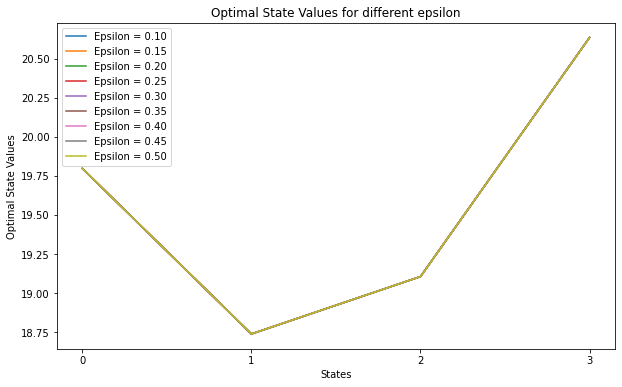

In [16]:
plt.figure(figsize = (10, 6))

for i in range(len(eps)):
    plt.plot(state_vals_eps[i], label = f'Epsilon = {"%.2f" % eps[i]}')
    
plt.xticks(np.arange(4))
plt.title("Optimal State Values for different epsilon")
plt.xlabel("States")
plt.ylabel("Optimal State Values")
plt.legend()
plt.show()